In [2]:
from power_calculator import calculate_power
import os
import pandas as pd
from scrape_cardlists import DATA_PATH
BASE_PWR_PATH = os.path.join(DATA_PATH, "decks", "baseline")
MANUAL_SAVE = os.path.join(DATA_PATH, "decks", "manual_rand")
GPT_SAVE = os.path.join(DATA_PATH, "completed")
DECKS = os.path.join(DATA_PATH, "decks")

In [34]:
import os
import ast
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compile_power(directory):
    data = []  # To hold dictionaries from files
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.basename(root)  # Get the current folder name
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                #print(file_path)
                with open(file_path, 'r+', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                    if lines:
                        try:
                            # Convert the last line to a dictionary
                            last_line_dict = ast.literal_eval(lines[-1].strip())
                            # Ensure it's actually a dictionary
                            if isinstance(last_line_dict, dict):
                                last_line_dict['folder'] = folder_name  # Add folder name to the dictionary
                                last_line_dict['commander'] = file
                                if (last_line_dict['cmc'] == 0):
                                    last_line_dict['cmc'] = 3
                                last_line_dict['overall'] = 2 / float(last_line_dict['cmc']) + ( int(last_line_dict['draw'])/2 + int(last_line_dict['ramp'])/2) / 2 + int(last_line_dict['interaction'])/20
                                data.append(last_line_dict)
                                lines[-1] = str(last_line_dict)
                                f.seek(0)
                                f.writelines(lines)
                        except (ValueError, SyntaxError):
                            print(f"Error processing file: {file_path}")
                            continue
    return pd.DataFrame(data)

# Replace 'path_to_your_directory' with the actual path to your directory
directory_path = 'path_to_your_directory'

df = compile_power(DECKS)
for col in df:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

df.head()

,overall,cmc,ramp,draw,interaction,folder,commander
0,17.471311,2.772727,32,35,0,baseline,AesiTyrantofGyreStrait.txt
1,1.284071,3.424242,1,0,9,baseline,AgrusKosEternalSoldier.txt
2,1.305837,3.953846,1,2,1,baseline,AkromaVisionofIxidor.txt
3,7.880612,3.769231,2,26,7,baseline,AlandraSkyDreamer.txt
4,8.996218,3.661538,4,29,4,baseline,AotheDawnSky.txt


In [35]:
df.to_pickle("../data/power.pkl")

In [36]:
df.groupby('folder').count()

,overall,cmc,ramp,draw,interaction,commander
folder,,,,,,
baseline,189,189,189,189,189,189
edh,189,189,189,189,189,189
gpt,189,189,189,189,189,189
manual_rand,189,189,189,189,189,189


In [37]:
df[df.columns.difference(['commander'])].groupby('folder').mean()

,cmc,draw,interaction,overall,ramp
folder,,,,,
baseline,3.452893,10.222222,7.222222,4.506141,3.994709
edh,2.616405,11.656085,8.206349,7.132086,12.052910
gpt,3.345469,12.005291,10.148148,5.900048,7.153439
manual_rand,3.327767,11.407407,8.883598,5.216341,5.259259


In [12]:
df

,overall,cmc,ramp,draw,interaction,folder,commander
0,4,2.772727,32,35,0,baseline,AesiTyrantofGyreStrait.txt
1,1,3.424242,1,0,9,baseline,AgrusKosEternalSoldier.txt
2,1,3.953846,1,2,1,baseline,AkromaVisionofIxidor.txt
3,4,3.769231,2,26,7,baseline,AlandraSkyDreamer.txt
4,4,3.661538,4,29,4,baseline,AotheDawnSky.txt
...,...,...,...,...,...,...,...
750,2,3.104478,1,0,4,manual_rand,XunYuWeiAdvisor.txt
751,4,3.029412,5,9,4,manual_rand,YaroktheDesecrated.txt
752,4,3.470588,5,9,9,manual_rand,YoshimaruEverFaithful.txt
753,3,3.029851,3,3,7,manual_rand,ZhangHeWeiGeneral.txt


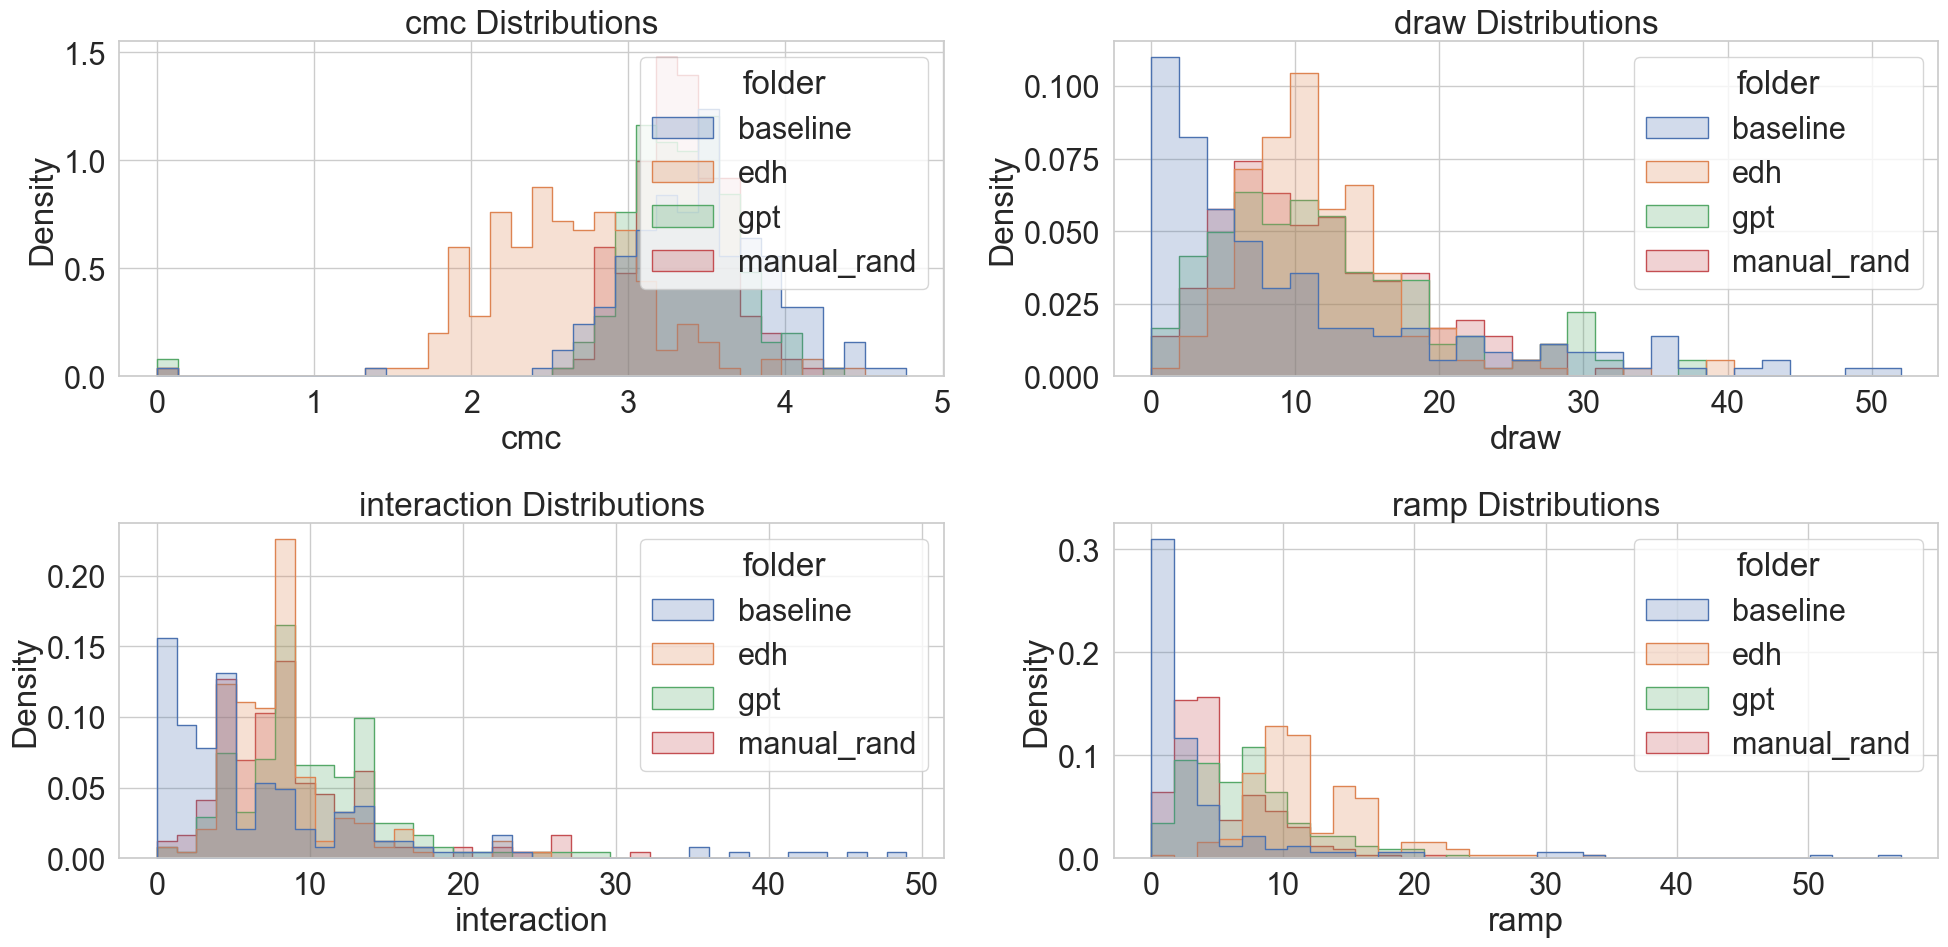

In [24]:
sns.set(style="whitegrid", font_scale=2)
plt.figure(figsize=(20, 10))

# Create a column list excluding 'folder'
columns = df.columns.difference(['folder', 'overall', 'commander'])

# Plotting
for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=column, hue="folder", element="step", stat="density", common_norm=False)
    plt.title(f'{column} Distributions')

plt.tight_layout()
plt.savefig("../docs/distributions.png")
plt.show()

In [7]:
df[df['cmc'] == 0]

,overall,cmc,ramp,draw,interaction,folder,commander
73,3,0.0,2,35,3,baseline,HidetsuguandKairi.txt
355,1,0.0,0,0,0,edh,TheFugitiveDoctor.txt
393,1,0.0,0,0,0,gpt,BartolomédelPresidio.txt
457,1,0.0,0,0,0,gpt,InameasOne.txt
611,1,0.0,6,14,7,manual_rand,ErtaiWizardAdept.txt


In [ ]:
from scipy.stats import f_oneway

for col in df.columns.difference(['folder']):
    # Similar setup as Kruskal-Wallis but for ANOVA
    data = [df[df['folder'] == folder][col] for folder in df['folder'].unique()]

    # Perform ANOVA
    stat, p = f_oneway(*data)

    print(col + ' Statistics= %.3f, p= %.3f' % (stat, p))
    if p > 0.05:
        print('Same means across all groups (fail to reject H0)')
    else:
        print('Different means across some groups (reject H0)')

cmc Statistics= 52.901, p= 0.000
Different means across some groups (reject H0)
draw Statistics= 3.417, p= 0.017
Different means across some groups (reject H0)
interaction Statistics= 2.358, p= 0.071
Same means across all groups (fail to reject H0)
overall Statistics= 162.982, p= 0.000
Different means across some groups (reject H0)
ramp Statistics= 44.858, p= 0.000
Different means across some groups (reject H0)


In [ ]:
df.columns.difference(['baseline'])

Index(['cmc', 'draw', 'folder', 'interaction', 'overall', 'ramp'], dtype='object')

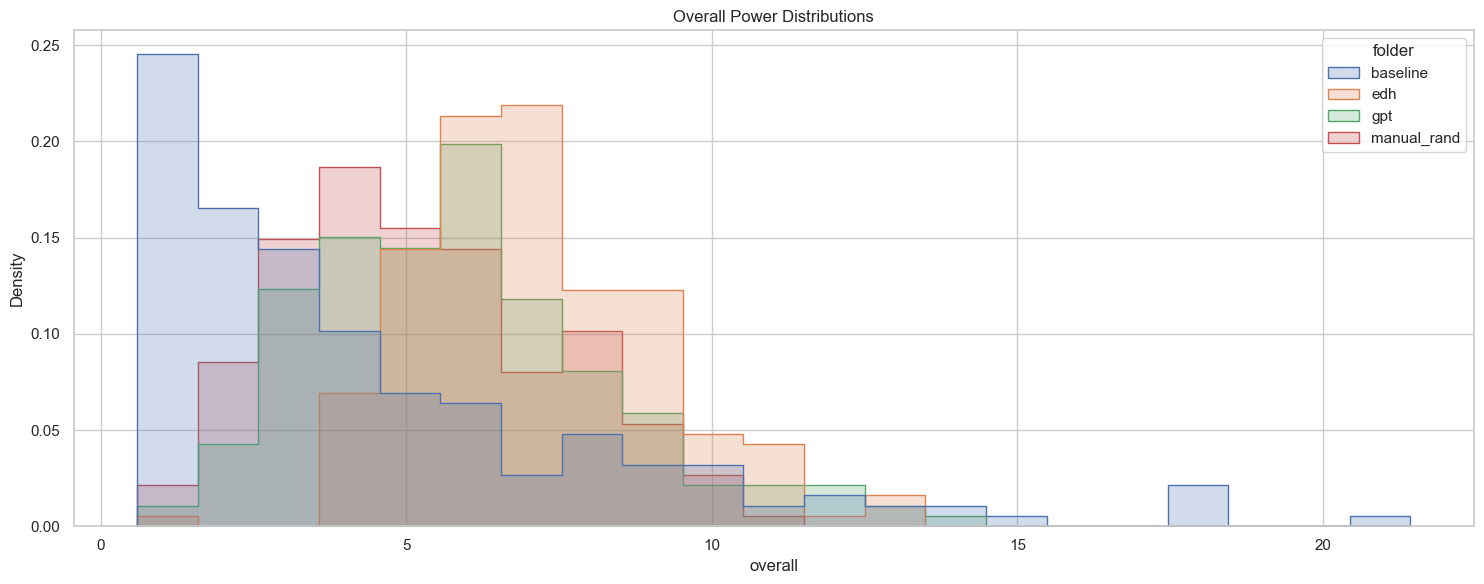

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'overall' is the column of interest
sns.set(style="whitegrid")

# Calculate appropriate bin edges to cover the full range of data without gaps
bin_edges = range(int(df['overall'].min()), int(df['overall'].max()) + 2)  # +2 to ensure the last data point is included

plt.figure(figsize=(15, 6))  # Adjust size as needed
sns.histplot(data=df, x='overall', hue='folder', binwidth=1, bins=bin_edges, stat="density", element="step", common_norm=False)
plt.title('Overall Power Distributions')
plt.tight_layout()
plt.savefig("../docs/power_distributions.png")
plt.show()